## Predicting hand written digits between 0 and 9 using the full MNIST Dataset

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.8MB/s 
     |████████████████████████████████| 1.2MB 10.0MB/s 
     |████████████████████████████████| 204kB 20.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [9]:
path = untar_data(URLs.MNIST)
print(path)
Path.BASE_PATH = path

path

/root/.fastai/data/mnist_png


Path('.')

In [13]:
# examine all of the paths required
all_paths = (path/'training').ls()
all_paths

(#10) [Path('training/1'),Path('training/3'),Path('training/6'),Path('training/8'),Path('training/0'),Path('training/5'),Path('training/4'),Path('training/2'),Path('training/7'),Path('training/9')]

In [19]:
get_tensors_from_path = lambda num, set_type: torch.stack([tensor(Image.open(file_url)) for file_url in (path/set_type/num).ls()]).float()/255

In [21]:
ones = get_tensors_from_path('1', 'training')
ones.shape

torch.Size([6742, 28, 28])

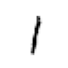

In [22]:
show_image(ones[0])

In [ ]:
numbers = [str(i) for i in range(10)]
all_train_list = [get_tensors_from_path(number, 'training') for number in numbers]

In [25]:
len(all_train_list), all_train_list[0].shape, all_train_list[1].shape

(10, torch.Size([5923, 28, 28]), torch.Size([6742, 28, 28]))